In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

2023-01-10 10:10:39.845349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 10:10:40.000184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 10:10:40.000215: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-10 10:10:40.711641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Introduction
This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know.

We develop our models using TensorFlow and TensorFlow Probability. TensorFlow Probability is a Python library built on top of TensorFlow. We are going to start with the basic objects that we can find in TensorFlow Probability and understand how can we manipulate them. We will increase complexity incrementally over the following weeks and combine our probabilistic models with deep learning on modern hardware (e.g. GPU).

As usual, the code is available on my GitHub.

# Deterministic vs. Probabilistic Deep Learning

Deep learning has become the dominant approach for a wide range of machine learning tasks, such as image and speech recognition, natural language processing, and reinforcement learning. A key feature of deep learning is the ability to learn complex, non-linear functions from large amounts of data. However, traditional deep learning models are deterministic, meaning they make the same predictions given the same inputs.

Deterministic deep learning models, such as feedforward neural networks, are trained to optimize a scalar-valued loss function, such as mean squared error or cross-entropy. The trained model produces a single prediction for each input, but does not provide any information about the uncertainty of the prediction. In contrast, probabilistic deep learning models, such as variational autoencoders (VAEs) and generative adversarial networks (GANs), are trained to optimize a probabilistic objective, such as the negative log-likelihood of the data or an approximate posterior distribution. These models provide a probabilistic characterization of the uncertainty in their predictions.

One of the main advantages of probabilistic deep learning models is the ability to generate new samples from the model. For example, a VAE can be used to generate new images that are similar to the training data, while a GAN can be used to generate new images that are different from the training data. Additionally, probabilistic deep learning models can be used for unsupervised learning, where the goal is to learn a compact representation of the data without any labels.Deep learning has become the dominant approach for a wide range of machine learning tasks, such as image and speech recognition, natural language processing, and reinforcement learning. A key feature of deep learning is the ability to learn complex, non-linear functions from large amounts of data. However, traditional deep learning models are deterministic, meaning they make the same predictions given the same inputs.

Deterministic deep learning models, such as feedforward neural networks, are trained to optimize a scalar-valued loss function, such as mean squared error or cross-entropy. The trained model produces a single prediction for each input, but does not provide any information about the uncertainty of the prediction. In contrast, probabilistic deep learning models, such as variational autoencoders (VAEs) and generative adversarial networks (GANs), are trained to optimize a probabilistic objective, such as the negative log-likelihood of the data or an approximate posterior distribution. These models provide a probabilistic characterization of the uncertainty in their predictions.
One of the main advantages of probabilistic deep learning models is the ability to generate new samples from the model. For example, a VAE can be used to generate new images that are similar to the training data, while a GAN can be used to generate new images that are different from the training data. Additionally, probabilistic deep learning models can be used for unsupervised learning, where the goal is to learn a compact representation of the data without any labels.

# Data and Approach

In this article, we employ the MNIST dataset and its corrupted counterpart as a means of evaluating the performance of our proposed method. The corrupted version of the MNIST dataset introduces an added level of complexity by way of grey spatters superimposed on the original images, making the task of classifying the handwritten digits more challenging.

Our objective is to construct a convolutional neural network (CNN) that effectively classifies the images of handwritten digits into 10 distinct classes. To this end, we make use of the aforementioned datasets, in order to provide a comprehensive evaluation of the performance of our proposed CNN architecture. The ultimate goal is to provide a CNN which can demonstrate robust performance, even in the presence of corrupted data.

In [2]:
def load_data(name):
    data_dir = os.path.join('data', name)
    x_train = 1 - np.load(os.path.join(data_dir, 'x_train.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    x_test  = 1 - np.load(os.path.join(data_dir, 'x_test.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)
    
    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, :, :], cmap='gray')
        ax[i].axis('off')
    plt.show()

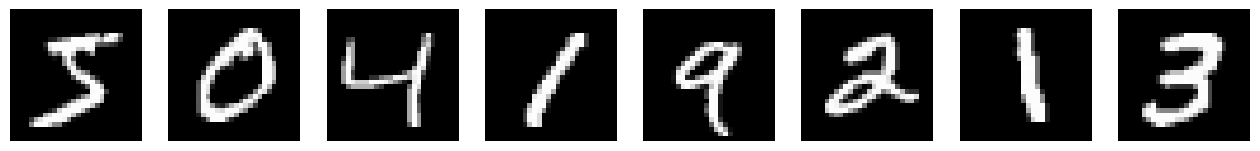

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

inspect_images(data=x_train, num_images=8)

In [4]:
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [20]:
(xy_c_train, xy_c_test) = tfds.load('mnist_corrupted/spatter',
                               split=['train', 'test'],
                               as_supervised=True)

In [6]:
def read_prefetch(dataset):
    x = []
    y = []
    for x_, y_ in dataset:
        x.append(x_)
        y.append(y_)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

x_c_train, y_c_train = read_prefetch(xy_c_train)
x_c_test, y_c_test = read_prefetch(xy_c_test)

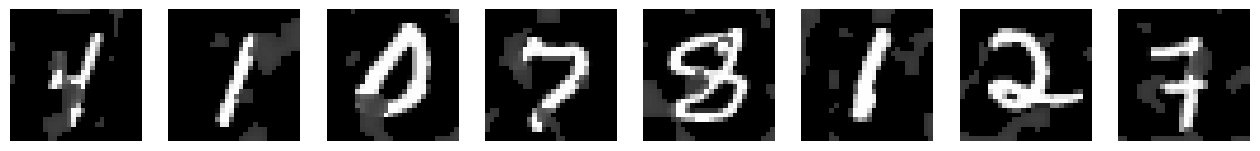

In [7]:
inspect_images(data=x_c_train, num_images=8)

# Deterministic Architecture

We begin by formally introducing the deterministic model, which is a convolutional neural network (CNN) classifier comprised of several key architectural components. Specifically, this model consists of:
1. A convolutional layer, in which the convolutional operation is performed by a set of 8 filters with a kernel size of 5x5 and 'VALID' padding, and the output is passed through a rectified linear unit (ReLU) activation function.
2. A max-pooling layer, in which the maximum value within non-overlapping windows of size 6x6 is taken, reducing the spatial dimensionality of the feature maps.
3. A flatten layer, in which the pooled feature maps are collapsed into a single vector, allowing for the final dense layer to have fully connected computations.
4. A dense layer, which is also known as fully-connected layer, has 10 units and applies a softmax activation function to obtain the final probability distribution over the class labels.

This CNN classifier architecture is designed to efficiently extract discriminative features and perform classification on high-dimensional image data.

In [8]:
def get_det_model(input_shape, loss, optimizer, metrics):
    
    model = Sequential([
        Conv2D(input_shape=input_shape,
              filters=8,
              kernel_size=(5,5),
              activation='relu',
              padding='valid'),
        MaxPooling2D(pool_size=(6,6)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [9]:
tf.random.set_seed(0)
deterministic_model = get_det_model(
    input_shape=(28, 28, 1), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


We have implemented the architecture discussed above, so now we are ready to start the training procedure.

In [10]:
deterministic_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 2.1986 - accuracy: 0.8423
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2248 - accuracy: 0.9470
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1678 - accuracy: 0.9563
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1428 - accuracy: 0.9626
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1336 - accuracy: 0.9641


Finally, we can check the accuracy on both datasets.

In [11]:
print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9659000039100647
Accuracy on corrupted MNIST test set:  0.902400016784668


# Probabilistic Architecture

In contrast to the deterministic model previously discussed, our probabilistic model introduces a new approach to outputting a distribution object, specifically a One-Hot Categorical distribution. This enables the modeling of aleatoric uncertainty on the image labels, allowing for a more comprehensive characterization of the model's predictions.
The One-Hot Categorical distribution is a discrete probability distribution over one-hot bit vectors, with the event dimension equal to K, the number of classes. It is mathematically equivalent to the Categorical distribution, which is a discrete probability distribution over positive integers, with the key distinction being that Categorical has an empty event dimension, whereas One-Hot Categorical has event dimension equal to K.

Our proposed probabilistic CNN architecture consists of:
1. A convolutional layer, in which the convolutional operation is performed by a set of 8 filters with a kernel size of 5x5 and 'VALID' padding, and the output is passed through a rectified linear unit (ReLU) activation function.
2. A max-pooling layer, in which the maximum value within non-overlapping windows of size 6x6 is taken, reducing the spatial dimensionality of the feature maps.
3. A flatten layer, in which the pooled feature maps are collapsed into a single vector, allowing for the final dense layer to have fully connected computations.
4. A dense layer, which is also known as fully-connected layer, with the number of units required to parameterize the probabilistic layer that follows.
5. A OneHotCategorical distribution layer, with an event shape equal to 10, corresponding to the 10 classes.

This novel architecture, incorporating One-Hot Categorical output distribution, enables the modeling of aleatoric uncertainty on the image labels, and allows for a more comprehensive characterization of the model's predictions.

In [12]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [13]:
def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    
    model = Sequential([
        Conv2D(input_shape=input_shape,
              filters=8,
              kernel_size=(5,5),
              activation='relu',
              padding='valid'),
        MaxPooling2D(pool_size=(6,6)),
        Flatten(),
        Dense(10),
        tfpl.OneHotCategorical(event_size=10,
                              convert_to_tensor_fn=tfd.Distribution.mode)
    ])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [14]:
tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1), 
    loss=nll, 
    optimizer=RMSprop(), 
    metrics=['accuracy'])
probabilistic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 one_hot_categorical (OneHot  ((None, 10),             0         
 Categorical)                 (None, 10))                        
                                                                 
Total params: 1,498
Trainable params: 1,498
Non-traina

Our implementation of the model is done. Take a moment to compare the implementation above with the one that we did earlier that implements a deterministic architecture. If you have any doubts about specific components that we defined for the probabilistic version of the model, e.g. the loss function, please refer to the earlier articles in this series. Once again, we can now start the training procedure.

In [15]:
probabilistic_model.fit(x_train, tf.keras.utils.to_categorical(y_train), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 2.0467 - accuracy: 0.8283
Epoch 2/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1950 - accuracy: 0.9458
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1545 - accuracy: 0.9574
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1381 - accuracy: 0.9611
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1332 - accuracy: 0.9635


Finally, we can check the accuracy of this version of the model. Note that the test accuracy of the probabilistic model is identical to the deterministic one. This is because the model architectures for both are equivalent; the only difference being that the probabilistic model returns a distribution object.

In [16]:
print('Accuracy on MNIST test set: ',
      str(probabilistic_model.evaluate(x_test, tf.keras.utils.to_categorical(y_test), verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(probabilistic_model.evaluate(x_c_test, tf.keras.utils.to_categorical(y_c_test), verbose=False)[1]))

Accuracy on MNIST test set:  0.9641000032424927
Accuracy on corrupted MNIST test set:  0.8906999826431274


# Results

The accuracy is an important metric to assess the performance of the model. Nonetheless, it is sometimes shallow, since it does not provide information about the uncertainty of the predictions. 

In this section, we go beyond the predicted label and provide a visual representation of the uncertainty in the predictions. To accomplish this, we sample the predictive distribution of the model and calculate percentiles of the resulting samples.

In [17]:
def plot_model_prediction(image, true_label, model):
    predicted_probabilities = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    probs = np.zeros((10, 10))
    for i in range(10):
        probs[i] = np.array(np.mean(tf.squeeze(predicted_probabilities.sample(100)).numpy(), axis=0))
    pct_2p5 = np.percentile(probs, 2.5, axis=0)
    pct_97p5 = np.percentile(probs, 97.5, axis=0)
    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

The model is very confident that the first image is a 7, which is correct. For the second image, the model struggles, assigning nonzero probabilities to many different classes.

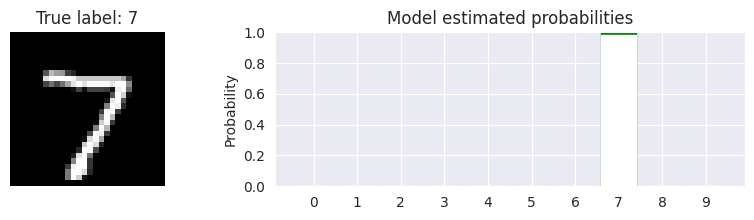

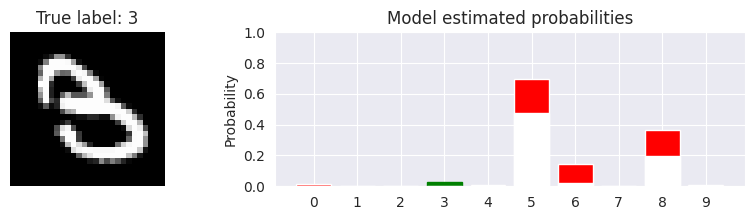

In [18]:
for i in [0, 18]:
    plot_model_prediction(x_test[i], np.squeeze(y_test[i]), probabilistic_model)

Once again the model is confident about its prediction of the first image. Despite the spatters, the number is still easy to identify. The second number is significantly harder to identify. The model still does a good job by predicting the right number, but also by showing uncertainty about that choice.

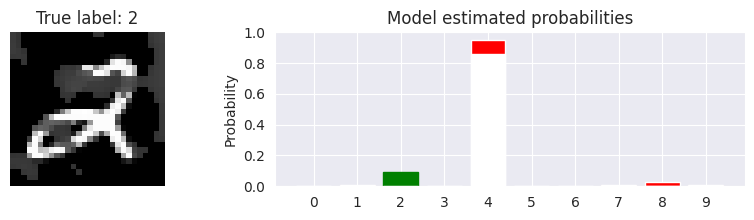

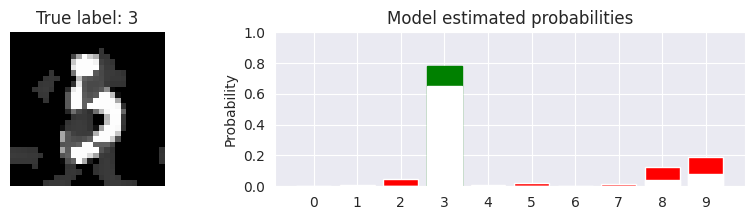

In [19]:
for i in [0, 17]:
    plot_model_prediction(x_c_test[i], np.squeeze(y_c_test[i]), probabilistic_model)

# Conclusion
In this article, we have discussed the key differences between deterministic and probabilistic deep learning models, with a focus on the use of these models for image classification tasks. By analyzing the performance of a CNN on the MNIST dataset and on the corrupted version of the same dataset, we have shown that probabilistic deep learning models can not only achieve similar accuracy levels to deterministic models, but also provide a probabilistic characterization of the uncertainty in their predictions.

One of the main advantages of probabilistic deep learning models is the ability to generate new samples from the model. This can be useful for tasks such as image synthesis or data augmentation, where the goal is to create new, realistic images from a given dataset. Additionally, probabilistic deep learning models can be used for unsupervised learning, where the goal is to learn a compact representation of the data without any labels.